# Map solar wind proton velocity from 1 AU to 30 RS using the HUX-b Model. 

The solar wind motion can be described as the fluid momentum equation in corotating frame of reference:
	
$$
-\Omega_{rot} \frac{\partial v}{\partial \phi} + (v \cdot \nabla)v = \frac{1}{\rho} \nabla P - \frac{G M_{s}}{r^2}e_{r}
$$

By neglecting magnetic field, pressure gradient and gravity, the fluid momentum equation reduces to the inviscid Burgers' equation.

$$
\frac{\partial v_{r}}{\partial \phi} = \frac{1}{\Omega_{rot}} v_{r} \frac{\partial v_{r}}{\partial r}
$$

where:

$${\Omega_{rot}}_{\theta = \pi/2} = \frac{2\pi}{25.38} \frac{1}{days} = \frac{2\pi}{25.38\cdot 86400} \frac{1}{sec}$$


Using the forward upwind difference algorithm, we get:

$$v_{i+1, j} = v_{i, j} + \frac{\Delta r \Omega_{rot}}{v_{i, j}}(\frac{v_{i, j+1} - v_{i, j}}{\Delta \Phi})$$


Backwards upwind difference algorithm, we get:

$$v_{i+1, j} = v_{i, j} + \frac{\Delta r \Omega_{rot}}{v_{i, j}}(\frac{v_{i, j-1} - v_{i, j}}{\Delta \Phi})$$


Effect of acceleration for HUX-b:

$$v_{acc}(r) = \alpha v_{ro}(1-\exp(-r/r_{h}))$$

$$v_{30R_{\odot}} = v_{30R_{\odot}} - v_{acc}(r)$$

In [4]:
import matplotlib as mpl
import numpy as np 
from tools.psihdf4 import rdhdf_3d
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from scipy import stats
import numpy,math
import scipy.optimize as optimization
from scipy.optimize import leastsq
import scipy
import pickle


%matplotlib notebook
plt.rcParams['figure.figsize'] = [10, 5] # default fig size.

# Step 1: Read in "data/vr_002.hdf".

In [5]:
# read the 3d hdf file. 
hdf_file_path = "data/vr002.hdf"
r, t, p, f = rdhdf_3d(hdf_file_path)

In [6]:
# force periodicity on f.
# since the last phi index is less than 2*pi, then we will append 2*pi to phi scale.
p = np.append(p, 2*np.pi) 
# append the first slice p=0 to velocity matrix. 
f = np.append(f,[f[0,:, :]],axis=0)

In [7]:
# change scalers units: 
# Theta: from radians to degrees. colatitude. 
t[0] = 0
t[-1] = np.pi
t_plot = np.pi/2 - t
t_plot = np.sin(t_plot)

In [8]:
# Phi: from radians to degrees. longitude.
p = (180/np.pi)*p

In [9]:
# Radius: from solar radii to km. 
# 1 solar radii = 695,700 km
r = (695700)*r

In [10]:
# Velocity profile: PSI convertion units conversion from MAS to cgs. 
# See: https://www.researchgate.net/figure/Converting-from-MAS-code-units-to-cgs-and-MKS_tbl1_228551881
f = (481.3711)*f

In [11]:
print("Velocity matrix shape: ", np.shape(f))
print("Phi dim: ", np.shape(f)[0])
print("Theta dim: ", np.shape(f)[1])
print("Radial dim: ", np.shape(f)[2])
print("Velocity matrix dtype: ", f.dtype)

Velocity matrix shape:  (129, 111, 140)
Phi dim:  129
Theta dim:  111
Radial dim:  140
Velocity matrix dtype:  float32


In [12]:
# slice velocity_mat, for r first index (30 solar radii).
v_initial = f[:, :, 0]
print("shape of v_iniital", np.shape(f))
# slice velocity_mat, for r last index(approx 1 AU).
v_final = f[:, :, -1]
print("shape of v_final", np.shape(f))

shape of v_iniital (129, 111, 140)
shape of v_final (129, 111, 140)


In [13]:
# NOTE: pcolorfast and pcolormesh want the coords of pixel corners not centers --> build a "half mesh" for p & t.
# - This means making an array that is n+1 size and has the midpoint positions of the original.
# - Here we clip the endpoints of the half mesh to the original bounds, vs extrapolate.
# - see also https://matplotlib.org/api/_as_gen/matplotlib.pyplot.pcolormesh.html.

cmap = 'gnuplot'

ph = np.concatenate([[p[0]], 0.5 * (p[1:] + p[:-1]), [p[-1]]])
th = np.concatenate([[t_plot[0]], 0.5 * (t_plot[1:] + t_plot[:-1]), [t_plot[-1]]])

<IPython.core.display.Javascript object>


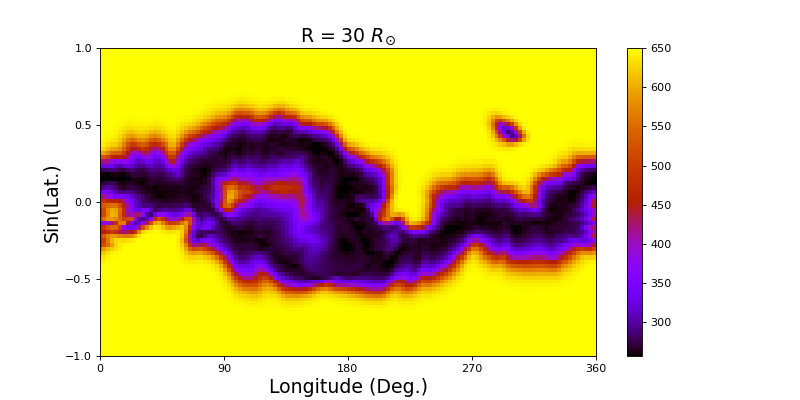

<IPython.core.display.Javascript object>


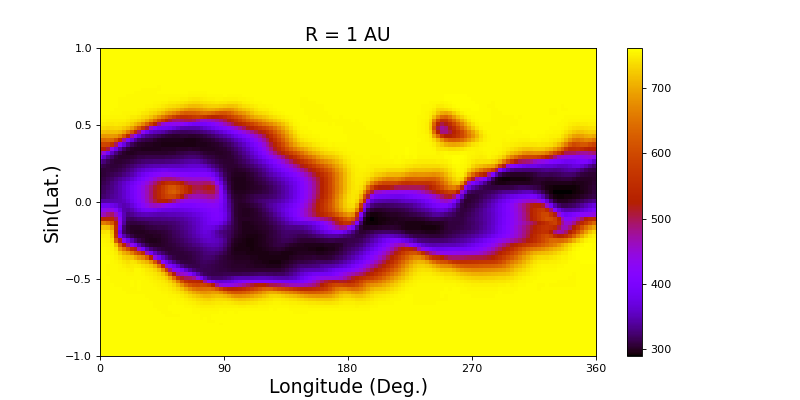

In [14]:
fig, ax = plt.subplots()
ax.set_ylim(-1, 1)
ax.set_xlim(0, 360)
ax.set_title("R = 30 $R_{\odot}$", fontsize=17)
ax.set_ylabel("Sin(Lat.)", fontsize=17)
ax.set_xlabel("Longitude (Deg.)", fontsize=17)
ax.set_yticks(ticks=[-1, -0.5, 0, 0.5, 1])
ax.set_xticks(ticks=[0, 90, 180, 270, 360])
_ = im = ax.pcolorfast(ph, th, v_initial.T, cmap=cmap)
_ = fig.colorbar(im, ax=ax)


fig, ax = plt.subplots()
ax.set_ylim(-1, 1)
ax.set_xlim(0, 360)
ax.set_title("R = 1 AU", fontsize=17)
ax.set_ylabel("Sin(Lat.)", fontsize=17)
ax.set_xlabel("Longitude (Deg.)", fontsize=17)
ax.set_yticks(ticks=[-1, -0.5, 0, 0.5, 1])
ax.set_xticks(ticks=[0, 90, 180, 270, 360])
_ = im = ax.pcolorfast(ph, th, v_final.T, cmap=cmap)
_ = fig.colorbar(im, ax=ax)

<IPython.core.display.Javascript object>


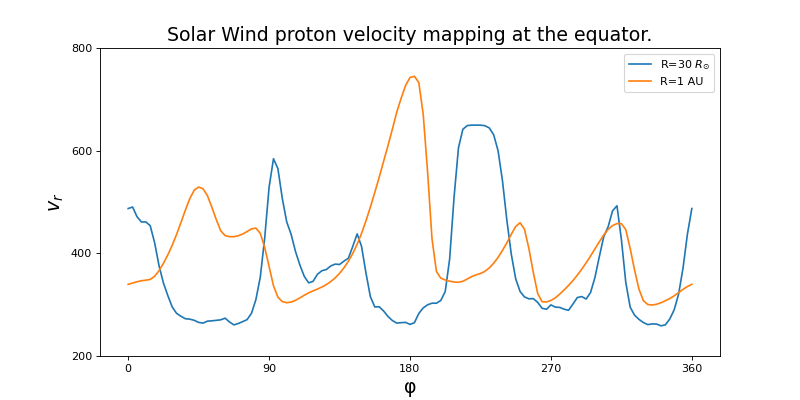

In [15]:
# plot the equator slice theta=90. 
solar_equator_r_30_radii = f[:, 55, 0]
solar_equator_r_1_au = f[:, 55, -1]
fig, ax = plt.subplots()
_ = ax.plot(p, solar_equator_r_30_radii, label="R=30 $R_{\odot}$")
_ = ax.plot(p, solar_equator_r_1_au, label="R=1 AU")
_ = ax.set_xlabel("\u03C6", fontsize=17)
_ = ax.set_ylabel('$v_{r}$', fontsize=17)
_ = ax.set_yticks(ticks=[200, 400, 600, 800])
_ = ax.set_xticks(ticks=[0, 90, 180, 270, 360])
_ = ax.set_title("Solar Wind proton velocity mapping at the equator.", fontsize=17)
_ = plt.legend()

# Step 2: Apply the HUX-b (Heliospheric Upwind Extrapolation) Model. Mapping from 1 AU to 30 Solar Radii.

In [16]:
# setting parameters. 
omega_rot = (2*np.pi)/(25.38*86400)
alpha = 0.15
rh = 50*695700

In [17]:
# change phi to be in radian units. 
p = (np.pi/180)*p 

In [18]:
# setting parameters. The phi and radial mesh spacing. 
dp_vec = p[1:] - p[:-1]
dr_vec = r[1:] - r[:-1]

print("average dp = ", dp_vec.mean())
print("average dr (km) = ", dr_vec.mean())

average dp =  0.04908738521234052
average dr (km) =  1033339.7602218519


<IPython.core.display.Javascript object>


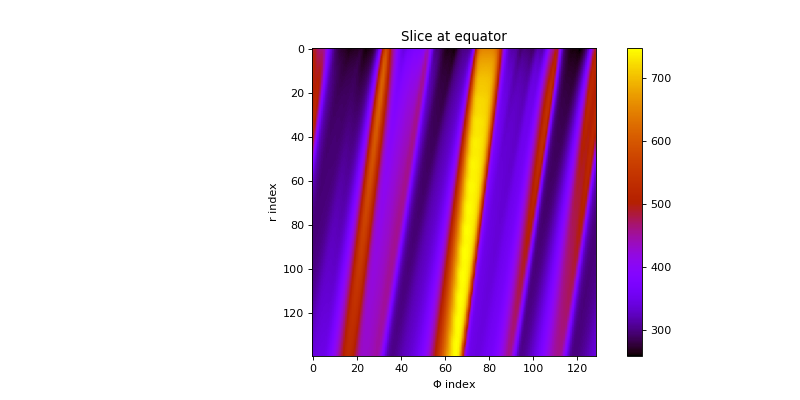

In [19]:
# initial slice
fig4, ax4 = plt.subplots()
_ = im = ax4.imshow(f[:, 55, :].T, cmap=cmap)
_ = fig4.colorbar(im, ax=ax4)
_ = ax4.set_title("Slice at equator")
_ = ax4.set_xlabel("$\Phi$ index")
_ = ax4.set_ylabel("r index")

In [20]:
def apply_forward_upwind_model(r_initial, omega_rot, dr_vec, dp_vec, alpha, rh, add_v_acc=True, r0=30*(695700)):
    """ Apply 1d forward upwind model to the inviscid burgers equation. r/phi grid."""

    v_next = np.zeros(len(dp_vec) + 1) # initialize v_next.
    v_prev = r_initial # v_previous, r = 30 RS. 
    
    # add acceleration before upwind. 
    if add_v_acc:
        v_acc = alpha * (v_prev*(1 - np.exp(-r0/rh)))
        v_prev = v_acc + v_prev

    for i in range(len(dr_vec)):
        for j in range(len(dp_vec) + 1):

            if j == len(dp_vec): # force periodicity 
                v_next[-1] = v_next[0]

            else:
                # courant condition
                if (omega_rot*dr_vec[i])/(dp_vec[j]*v_prev[j]) > 1:
                    print("CFL violated", dr_vec[i] - dp_vec[j]*v_prev[j]/omega_rot)
                    raise ValueError('CFL violated')
                    return False

                frac1 = (v_prev[j+1] - v_prev[j]) / v_prev[j]
                frac2 = (omega_rot * dr_vec[i]) / dp_vec[j]
                v_next[j] = v_prev[j] + frac1*frac2
        
        # update v_prev to be the current v. np.copy- deep copy so when we modify 
        # v_next v_prev does not change. 
        v_prev = np.copy(v_next)

    return v_next

In [21]:
def apply_backwards_upwind_model(r_final, omega_rot, dr_vec, dp_vec, alpha, rh, add_v_acc=True, r0=30*(695700)):
    """ Apply 1d backwards upwind model to the inviscid burgers equation. r/phi grid."""
    
    v_next = np.zeros(len(dp_vec)+1) # initialize v_next.
    v_prev = r_final # v_previous, r = 1 AU. 
            
    for i in range(len(dr_vec)):
        for j in range(len(dp_vec) + 1):
            
            if j != len(dp_vec):
                # courant condition
                if (omega_rot*dr_vec[i])/(dp_vec[j]*v_prev[j]) > 1:
                    print("CFL violated", dr_vec[i] - dp_vec[j]*v_prev[j]/omega_rot) 
                    raise ValueError('CFL violated')
                    return False
                    
                frac2 = (omega_rot * dr_vec[i]) / dp_vec[j]
            else:
                frac2 = (omega_rot * dr_vec[i]) / dp_vec[0]
                
            frac1 = (v_prev[j-1] - v_prev[j]) / v_prev[j]
            v_next[j] = v_prev[j] + frac1*frac2
            
        # update v_prev to be the current v. np.copy- deep copy so when we modify 
        # v_next v_prev does not change. 
        v_prev = np.copy(v_next)
            
    # add acceleration after upwind. 
    if add_v_acc:
        v_acc = alpha * (v_next*(1 - np.exp(-r0/rh)))
        v_next = -v_acc + v_next
            
    return v_next

In [22]:
solar_equator_r_30_radii = f[:, 55, 0]
solar_equator_r_1_au = f[:, 55, -1]

In [23]:
res_f = apply_forward_upwind_model(solar_equator_r_30_radii, omega_rot, dr_vec, dp_vec, alpha, rh)
res_b = apply_backwards_upwind_model(solar_equator_r_1_au, omega_rot, dr_vec, dp_vec, alpha, rh)

<IPython.core.display.Javascript object>


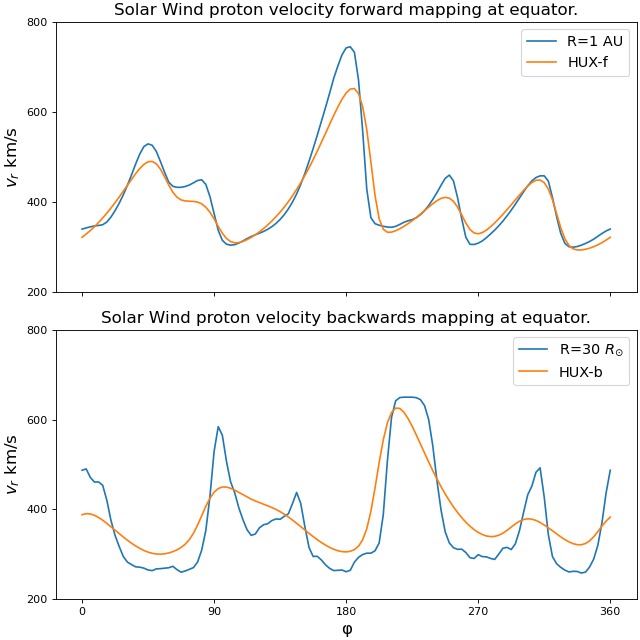

In [24]:
# plot the equator slice theta=90. 
plt.rcParams['figure.figsize'] = [8, 8] # default fig size.

fig, ax = plt.subplots(nrows=2, ncols=1, constrained_layout=True, sharex=True)

_ = ax[0].plot((180/np.pi)*p, solar_equator_r_1_au, label="R=1 AU")
_ = ax[0].plot((180/np.pi)*p, res_f, label="HUX-f")
_ = ax[0].set_ylabel('$v_{r}$ km/s', fontsize=15)
_ = ax[0].set_yticks(ticks=[200, 400, 600, 800])
_ = ax[0].set_xticks(ticks=[0, 90, 180, 270, 360])
_ = ax[0].set_title("Solar Wind proton velocity forward mapping at equator.", fontsize=15)
_ = ax[0].legend(fontsize=13)


_ = ax[1].plot((180/np.pi)*p, solar_equator_r_30_radii, label="R=30 $R_{\odot}$")
_ = ax[1].plot((180/np.pi)*p, res_b, label="HUX-b")
_ = ax[1].set_ylabel('$v_{r}$ km/s', fontsize=15)
_ = ax[1].set_xlabel("\u03C6", fontsize=15)
_ = ax[1].set_yticks(ticks=[200, 400, 600, 800])
_ = ax[1].set_xticks(ticks=[0, 90, 180, 270, 360])
_ = ax[1].set_title("Solar Wind proton velocity backwards mapping at equator.", fontsize=15)
_ = ax[1].legend(fontsize=13)

# Step 3: Apply HUX-b mapping to all slices in theta (latitude).

In [25]:
# get the differential rotation at different latitudes. 
def get_omega_rot(theta, omega_rot_at_equator=25.38):
    w_t = -2.77*np.pi/180
    res = 2*np.pi/omega_rot_at_equator + w_t*(np.cos(theta)**2)
    days = (res/(2*np.pi))**-1
    return days

In [26]:
upwind_approx = np.ones((len(p), len(t)))
for ii in range(len(t)):
    omega_rot = 2*np.pi/(get_omega_rot(t[ii])*86400)
    upwind_approx[:, ii] = apply_backwards_upwind_model(f[:, ii, -1], omega_rot, dr_vec, dp_vec, alpha, rh)

<IPython.core.display.Javascript object>


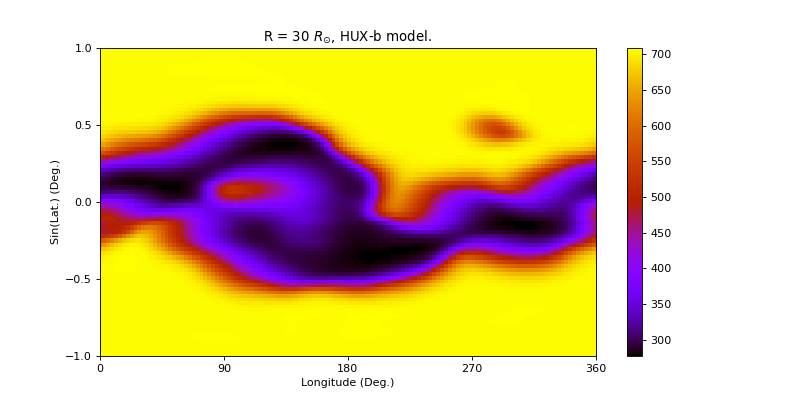

<IPython.core.display.Javascript object>


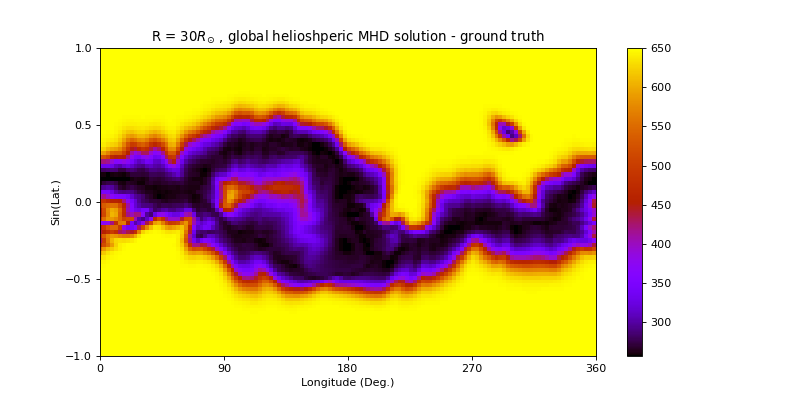

In [27]:
plt.rcParams['figure.figsize'] = [10, 5] # default fig size.

fig1, ax1 = plt.subplots()
ax1.set_ylim(-1, 1)
ax1.set_xlim(0, 360)
ax1.set_title("R = 30 $R_{\odot}$, HUX-b model. ")
ax1.set_ylabel("Sin(Lat.) (Deg.)")
ax1.set_xlabel("Longitude (Deg.)")
ax1.set_yticks(ticks=[-1, -0.5, 0, 0.5, 1])
ax1.set_xticks(ticks=[0, 90, 180, 270, 360])
_ = im = ax1.pcolorfast(ph, th, upwind_approx.T, cmap=cmap)
_ = fig1.colorbar(im, ax=ax1)

fig2, ax2 = plt.subplots()
ax2.set_ylim(-1, 1)
ax2.set_xlim(0, 360)
ax2.set_title("R = 30$R_{\odot}$ , global helioshperic MHD solution - ground truth")
ax2.set_ylabel("Sin(Lat.)")
ax2.set_xlabel("Longitude (Deg.)")
ax2.set_yticks(ticks=[-1, -0.5, 0, 0.5, 1])
ax2.set_xticks(ticks=[0, 90, 180, 270, 360])
_ = im = ax2.pcolorfast(ph, th, v_initial.T, cmap=cmap)
_ = fig2.colorbar(im, ax=ax2)

<IPython.core.display.Javascript object>


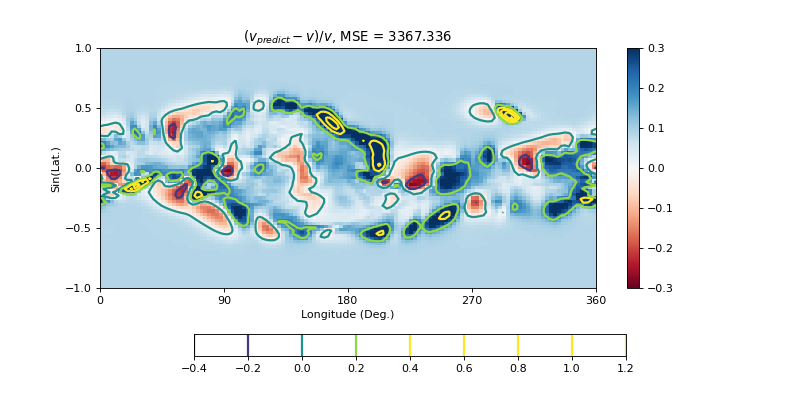

In [28]:
fig, ax = plt.subplots()
ax.set_ylim(-1, 1)
ax.set_xlim(0, 360)
ax.set_title("$ (v_{predict} - v) / v$, MSE = " + str(round(np.square(np.subtract(upwind_approx, v_initial)).mean(), 3)))
ax.set_ylabel("Sin(Lat.)")
ax.set_xlabel("Longitude (Deg.)")
ax.set_yticks(ticks=[-1, -0.5, 0, 0.5, 1])
ax.set_xticks(ticks=[0, 90, 180, 270, 360])
_ = im1 = ax.contour((180/np.pi)*p , t_plot, np.subtract(upwind_approx.T, v_initial.T)/v_initial.T, linewidths=2, vmin=-0.3, vmax=0.3)
_ = im2 = ax.pcolorfast(ph, th, np.subtract(upwind_approx.T, v_initial.T)/v_initial.T, cmap="RdBu", vmin=-0.3, vmax=0.3)
_ = fig.colorbar(im1, ax=ax, orientation="horizontal", fraction=0.07, anchor=(2,0.0))
_ = fig.colorbar(im2, ax=ax)

<IPython.core.display.Javascript object>


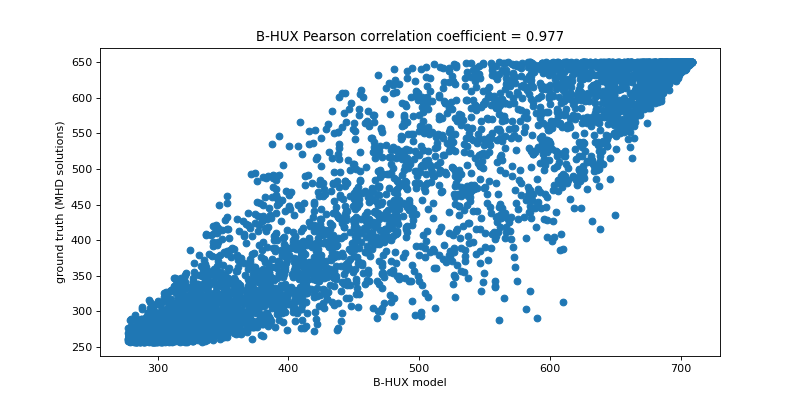

In [29]:
fig, ax = plt.subplots()
_ = ax.scatter(np.matrix.flatten(upwind_approx), np.matrix.flatten(v_initial))
_ = ax.set_xlabel("B-HUX model")
_ = ax.set_ylabel("ground truth (MHD solutions)" )
_ = ax.set_title("B-HUX Pearson correlation coefficient = " + str(round(stats.pearsonr(np.matrix.flatten(upwind_approx), np.matrix.flatten(v_initial))[0], 3)))

In [31]:
print("HUX-b pearson correlation coefficient at equator = ", stats.pearsonr(np.matrix.flatten(res_b), np.matrix.flatten(solar_equator_r_30_radii))[0])

HUX-b pearson correlation coefficient at equator =  0.8453006916793291


# Optimize Free parameters $\alpha$ and $r_{h}$- method: Nonlinear least squares fit. 

##  ±7.25 in latitude.

In [32]:
r_n, t_n, p_n, f_n = rdhdf_3d(hdf_file_path)
t = t_n[51:60]
print("t interval = " + str(t[0]*180/np.pi) + " to " + str(t[-1]*180/np.pi) + " deg")

t interval = 83.39449240721298 to 96.60550577155418 deg


In [35]:
omega_rot_vec = np.zeros(9)
for ii in range(len(omega_rot_vec)):
    omega_rot_vec[ii] = 2*np.pi/(get_omega_rot(t[ii], 25.38)*86400)

In [38]:
# create the model function with free - parameters: [alpha, rh]. 
model = lambda r_initial, alpha, rh: apply_backwards_upwind_model(r_initial, omega_rot, dr_vec, dp_vec, alpha, rh)

In [39]:
# create the model function with free - parameters: [alpha, rh]. 
optimial_free_params = np.zeros((2, len(omega_rot_vec)))

for ii in range(0, len(omega_rot_vec)):
    
    omega_rot = omega_rot_vec[ii]
    
    popt, _ = scipy.optimize.curve_fit(f=model, xdata=v_final[:, 51+ii], ydata=v_initial[:, 51+ii], p0=[0.15, 50*(695700)], bounds=[[0,0],[1,90*(695700)]])
    
    optimial_free_params[0, ii] = popt[0]
    optimial_free_params[1, ii] = popt[1]

<IPython.core.display.Javascript object>


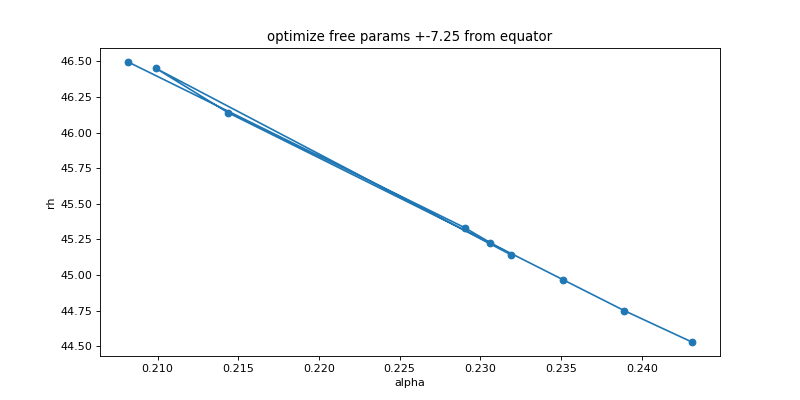

In [40]:
fig, ax = plt.subplots()
_ = ax.plot(optimial_free_params[0], optimial_free_params[1]/(695700))
_ = ax.scatter(optimial_free_params[0], optimial_free_params[1]/(695700))
#_ = ax.plot(x1, x1*a1 + b1, 'k', label="Linear fit")
_ = ax.set_ylabel("rh")
_ = ax.set_xlabel("alpha")
#_ = ax.legend()
_ = ax.set_title("optimize free params +-7.25 from equator")

In [41]:
print("optimal rh = ", np.mean(optimial_free_params[1]/(695700)))

optimal rh =  45.448280666654725


In [42]:
print("optimal alpha = ", np.mean(optimial_free_params[0]))

optimal alpha =  0.22678409444839534


In [43]:
opt_eq = apply_backwards_upwind_model(solar_equator_r_1_au, omega_rot, dr_vec, dp_vec, optimial_free_params[0][4], optimial_free_params[1][4])

<IPython.core.display.Javascript object>


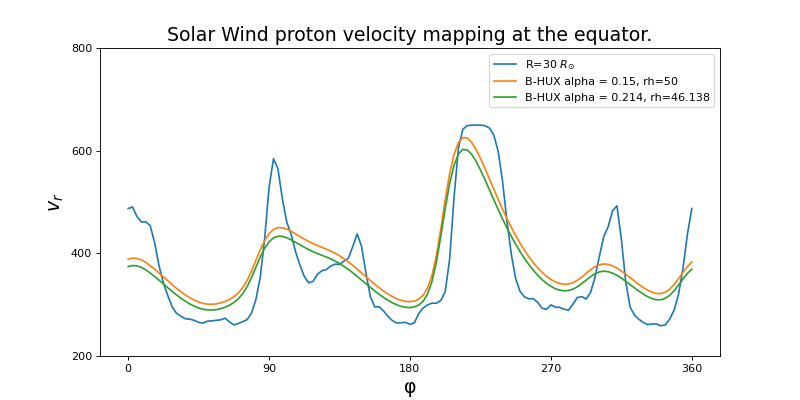

In [54]:
# plot the equator slice theta=90. 
plt.rcParams['figure.figsize'] = [10, 5] # default fig size.

fig, ax = plt.subplots()
_ = ax.plot(180*p/np.pi, solar_equator_r_30_radii, label="R=30 $R_{\odot}$")
_ = ax.plot(180*p/np.pi, res_b, label="B-HUX alpha = 0.15, rh=50")
_ = ax.plot(180*p/np.pi, opt_eq, label="B-HUX alpha = " + str(round(optimial_free_params[0][4], 3))+ ", rh=" + str(round(optimial_free_params[1][4]/(695700), 3)))
_ = ax.set_xlabel("\u03C6", fontsize=17)
_ = ax.set_ylabel('$v_{r}$', fontsize=17)
_ = ax.set_yticks(ticks=[200, 400, 600, 800])
_ = ax.set_xticks(ticks=[0, 90, 180, 270, 360])
_ = ax.set_title("Solar Wind proton velocity mapping at the equator.", fontsize=17)
_ = plt.legend()

In [50]:
print("MSE for alpha=0.15 and rh=50 at the equator = ", np.square(np.subtract(res_b, solar_equator_r_30_radii)).mean())
print("MSE for alpha=0.214 and rh=46.138 at the equator = ", np.square(np.subtract(opt_eq, solar_equator_r_30_radii)).mean())

MSE for alpha=0.15 and rh=50 at the equator =  4056.7550222522214
MSE for alpha=0.214 and rh=46.138 at the equator =  3862.747906317843


In [51]:
print("MSE for alpha=0.15 and rh=50 for +-7.25 deg in latitude = ", np.square(np.subtract(upwind_approx[:, 51:60], v_initial[:, 51:60])).mean())

MSE for alpha=0.15 and rh=50 for +-7.25 deg in latitude =  3760.262390147232


In [52]:
opt_approx = np.ones((len(p), len(t)))
for ii in range(len(t)):
    omega_rot = 2*np.pi/(get_omega_rot(t[ii])*86400)
    opt_approx[:, ii] = apply_backwards_upwind_model(f[:, 51 + ii, -1], omega_rot, dr_vec, dp_vec, np.mean(optimial_free_params[0]), np.mean(optimial_free_params[1]))

In [53]:
print("MSE for alpha=" + str(round(np.mean(optimial_free_params[0]),3)) +" and rh=" + str(round(np.mean(optimial_free_params[1])/(695700), 3)) + " for +-7.25 deg in latitude = " + str(np.square(np.subtract(opt_approx, v_initial[:, 51:60])).mean()))

MSE for alpha=0.227 and rh=45.448 for +-7.25 deg in latitude = 3424.8944744879404
